# StudyKB MVP: PDF classification, extraction (text & OCR), layout visuals, unified blocks

This notebook builds an end-to-end MVP for your study knowledge base:

- Detects file type: text-PDF vs scanned/GoodNotes-like
- Extracts text from text-PDFs with block geometry
- Rasterizes pages and OCRs scanned/GoodNotes PDFs (rus+eng)
- Detects simple color highlights (yellow/green/pink) and associates them with text
- Visualizes bounding boxes and overlays
- Normalizes to a unified block format per page

You only need to set the 3 file paths below and run all cells. Optional advanced cells are included for future upgrades (layout models, handwriting recognition).


## Configuration

Set paths to three example PDFs. You can include any mix: text-based, scanned, or GoodNotes-exported. The notebook will auto-classify per file/page.


In [18]:
# --- USER CONFIG ---
PDF_PATHS = [
    "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/Generative ML/Lectures.pdf"
]

# How many pages to process per file for demo
MAX_PAGES = 3

# DPI for rasterization (scanned/GoodNotes)
RASTER_DPI = 300

# OCR languages; install with Tesseract (e.g., brew install tesseract-lang)
OCR_LANG = "rus+eng"

# Visualization options
SHOW_FIGSIZE = (12, 16)



## Dependencies

The cell below attempts to install required Python packages. For OCR, we prefer Tesseract.
- macOS: `brew install tesseract tesseract-lang` (for `rus`)
- If Tesseract is unavailable, the notebook can fallback to `easyocr` (heavier download).


In [19]:
import sys, subprocess, importlib

def pip_install(pkg):
    try:
        importlib.import_module(pkg.split("[",1)[0].split("==",1)[0].replace("-","_"))
        return
    except Exception:
        pass
    print(f"Installing {pkg}...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])

# for pkg in [
#     "pymupdf",          # fitz
#     "pytesseract",
#     "Pillow",
#     "opencv-python-headless",
#     "numpy",
#     "matplotlib",
#     "langdetect",
# ]:
#     pip_install(pkg)

# Optional fallback OCR
try:
    import pytesseract  # noqa: F401
    TESS_AVAILABLE = True
except Exception:
    TESS_AVAILABLE = False
    pip_install("easyocr")

print("Tesseract available:", TESS_AVAILABLE)



Tesseract available: True


In [20]:
import os
import io
import math
import json
from typing import List, Dict, Any, Tuple

import fitz  # PyMuPDF
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

try:
    import pytesseract
except Exception:
    pytesseract = None

try:
    import easyocr
except Exception:
    easyocr = None

import cv2
from langdetect import detect as lang_detect

# Utility
def ensure_rgb(img: Image.Image) -> Image.Image:
    if img.mode != "RGB":
        return img.convert("RGB")
    return img




## Classification heuristics (text-PDF vs scanned/GoodNotes)

We check:
- PDF metadata for producer/creator hints (e.g., GoodNotes)
- Text extraction ratio on first page(s)
- If little/no extractable text, treat as scanned/GoodNotes-like


In [21]:
def pdf_metadata_hints(doc: fitz.Document) -> Dict[str, Any]:
    meta = doc.metadata or {}
    hints = {
        "producer": (meta.get("producer") or meta.get("Producer") or "").lower(),
        "creator": (meta.get("creator") or meta.get("Creator") or "").lower(),
        "title": (meta.get("title") or meta.get("Title") or ""),
    }
    return hints

def page_text_density(page: fitz.Page) -> float:
    blocks = page.get_text("blocks") or []
    chars = sum(len(b[4]) for b in blocks if len(b) >= 5)
    area = page.rect.width * page.rect.height
    return chars / max(area, 1.0)

def classify_pdf(path: str, sample_pages: int = 2) -> Dict[str, Any]:
    doc = fitz.open(path)
    hints = pdf_metadata_hints(doc)
    goodnotes_hint = ("goodnotes" in hints["producer"]) or ("goodnotes" in hints["creator"]) or ("skia/pdf" in hints["producer"]) or ("notability" in hints["producer"]) or ("goodnotes" in path.lower())

    densities = []
    for i in range(min(sample_pages, len(doc))):
        densities.append(page_text_density(doc[i]))
    avg_density = float(np.mean(densities)) if densities else 0.0

    # Heuristic thresholds
    is_text_pdf = avg_density > 1e-4  # depends on DPI-independent units
    is_scanned_like = not is_text_pdf

    kind = "text_pdf" if is_text_pdf else ("goodnotes_like" if goodnotes_hint else "scanned_pdf")

    return {
        "kind": kind,
        "avg_text_density": avg_density,
        "goodnotes_hint": goodnotes_hint,
        "meta": hints,
        "num_pages": len(doc),
    }



## Rasterization and OCR

- Rasterize pages with PyMuPDF at chosen DPI
- OCR via Tesseract (preferred) or EasyOCR fallback
- Return word-level boxes for visualization and normalization


In [22]:
def page_to_image(page: fitz.Page, dpi: int = 300) -> Image.Image:
    mat = fitz.Matrix(dpi/72, dpi/72)
    pix = page.get_pixmap(matrix=mat, alpha=False)
    img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
    return img


def ocr_tesseract(img: Image.Image, lang: str = "eng") -> List[Dict[str, Any]]:
    """Return list of words with bbox and conf."""
    if pytesseract is None:
        return []
    img = ensure_rgb(img)
    data = pytesseract.image_to_data(img, lang=lang, output_type=pytesseract.Output.DICT)
    words = []
    n = len(data["text"]) if data and "text" in data else 0
    for i in range(n):
        text = (data["text"][i] or "").strip()
        if not text:
            continue
        x, y, w, h = data["left"][i], data["top"][i], data["width"][i], data["height"][i]
        conf = float(data.get("conf", ["-1"][0])[i]) if data.get("conf") else -1.0
        words.append({
            "text": text,
            "bbox": [int(x), int(y), int(x+w), int(y+h)],
            "conf": conf,
            "engine": "tesseract",
        })
    return words


def ocr_easyocr(img: Image.Image, lang_list: List[str]) -> List[Dict[str, Any]]:
    if easyocr is None:
        return []
    reader = easyocr.Reader(lang_list, gpu=False, verbose=False)
    img = np.array(ensure_rgb(img))
    results = reader.readtext(img)
    words = []
    for bbox, text, conf in results:
        # bbox is 4 points
        xs = [p[0] for p in bbox]
        ys = [p[1] for p in bbox]
        words.append({
            "text": text,
            "bbox": [int(min(xs)), int(min(ys)), int(max(xs)), int(max(ys))],
            "conf": float(conf),
            "engine": "easyocr",
        })
    return words


def run_ocr(img: Image.Image, lang: str = "eng") -> List[Dict[str, Any]]:
    if pytesseract is not None:
        return ocr_tesseract(img, lang=lang)
    # Fallback mapping
    lang_map = {
        "eng": ["en"],
        "rus": ["ru"],
        "rus+eng": ["ru", "en"],
    }
    langs = lang_map.get(lang, ["en"])
    return ocr_easyocr(img, langs)



## Highlight detection (simple HSV masks)

Detect common highlight colors (yellow/green/pink) on rasterized pages. Associate masks with nearest text boxes later.


In [23]:
def detect_highlights(img: Image.Image) -> Dict[str, Any]:
    """Return binary masks for common highlight colors in BGR/HSV ranges."""
    bgr = cv2.cvtColor(np.array(ensure_rgb(img)), cv2.COLOR_RGB2BGR)
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)

    # Color ranges (tunable)
    ranges = {
        "yellow": [(20, 80, 160), (35, 255, 255)],
        "green":  [(40, 40, 120), (85, 255, 255)],
        "pink":   [(140, 40, 120), (175, 255, 255)],
    }
    masks = {}
    for name, (low, high) in ranges.items():
        low = np.array(low, dtype=np.uint8)
        high = np.array(high, dtype=np.uint8)
        mask = cv2.inRange(hsv, low, high)
        # Morphology clean-up
        kernel = np.ones((5,5), np.uint8)
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        masks[name] = mask
    return {"masks": masks}


def mask_contours(mask: np.ndarray, min_area: int = 100) -> List[List[int]]:
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w*h >= min_area:
            boxes.append([x, y, x+w, y+h])
    return boxes



## Text-PDF extraction with PyMuPDF blocks

We extract geometric blocks: `(x0,y0,x1,y1,text, block_no, line_no, span_no)` and convert to normalized blocks.


In [24]:
def extract_text_blocks(page: fitz.Page) -> List[Dict[str, Any]]:
    blocks = page.get_text("blocks") or []
    out = []
    for bi, b in enumerate(blocks):
        # b: (x0,y0,x1,y1,text, block_no, block_type, ...)
        if len(b) < 5:
            continue
        x0, y0, x1, y1, text = b[:5]
        if not (text or "").strip():
            continue
        # Language heuristic on small snippet
        snippet = text.strip()[:200]
        try:
            lang = lang_detect(snippet) if snippet else ""
        except Exception:
            lang = ""
        out.append({
            "type": "text",
            "text": text,
            "bbox": [int(x0), int(y0), int(x1), int(y1)],
            "lang": lang,
            "source": "pymupdf_blocks",
        })
    return out



## Visualization helpers

Overlay word and highlight boxes on rendered page images for inspection.


In [25]:
def draw_boxes(img: Image.Image, boxes: List[List[int]], color=(255,0,0), width=2) -> Image.Image:
    im = img.copy()
    draw = ImageDraw.Draw(im)
    for x0,y0,x1,y1 in boxes:
        draw.rectangle([x0,y0,x1,y1], outline=color, width=width)
    return im


def visualize_page_with_overlays(img: Image.Image, words: List[Dict[str, Any]], highlights: Dict[str, Any]):
    fig = plt.figure(figsize=SHOW_FIGSIZE)
    plt.imshow(img)
    ax = plt.gca()

    # Words
    for w in words:
        x0,y0,x1,y1 = w["bbox"]
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    # Highlights
    for cname, mask in (highlights.get("masks") or {}).items():
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < 200:
                continue
            rect = plt.Rectangle((x,y), w, h, fill=False, edgecolor='yellow' if cname=="yellow" else ('green' if cname=="green" else 'magenta'), linewidth=2)
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()



## Normalized block model

Create a simple unified structure per page: blocks of `text` (with bbox, lang), `highlight` regions, and `word` boxes from OCR.


In [26]:
def unify_text_pdf_page(page: fitz.Page) -> Dict[str, Any]:
    blocks = extract_text_blocks(page)
    # Also render image for visualization (optional)
    img = page_to_image(page, dpi=RASTER_DPI)
    return {
        "image": img,
        "blocks": blocks,
        "words": [],
        "highlights": {},
        "kind": "text_pdf",
    }


def unify_scanned_like_page(page: fitz.Page) -> Dict[str, Any]:
    img = page_to_image(page, dpi=RASTER_DPI)
    words = run_ocr(img, lang=OCR_LANG)
    hl = detect_highlights(img)
    return {
        "image": img,
        "blocks": [],
        "words": words,
        "highlights": hl,
        "kind": "scanned_or_gn",
    }


def page_unified_preview(unified: Dict[str, Any]):
    img = unified["image"]
    words = unified.get("words", [])
    highlights = unified.get("highlights", {})
    visualize_page_with_overlays(img, words, highlights)




## End-to-end demo for 3 PDFs

For each file: classify, then process first `MAX_PAGES` pages. Visualize page overlays and show a few normalized blocks/words.



=== Lectures.pdf ===
{
  "kind": "text_pdf",
  "avg_text_density": 0.001326,
  "goodnotes_hint": false,
  "meta": {
    "producer": "ios version 17.5.1 (build 21f91) quartz pdfcontext",
    "creator": "",
    "title": ""
  },
  "num_pages": 15
}
Page 1: 69 text blocks
{'type': 'text', 'lang': 'bg', 'bbox': [29, 12, 970, 42]} 1еĸциа1о С#) Хопробуо свестиĸминилизации  ...
{'type': 'text', 'lang': 'ca', 'bbox': [21, 45, 175, 63]} oFormal suetement  ...
{'type': 'text', 'lang': 'sq', 'bbox': [688, 45, 839, 63]} Asht  ...


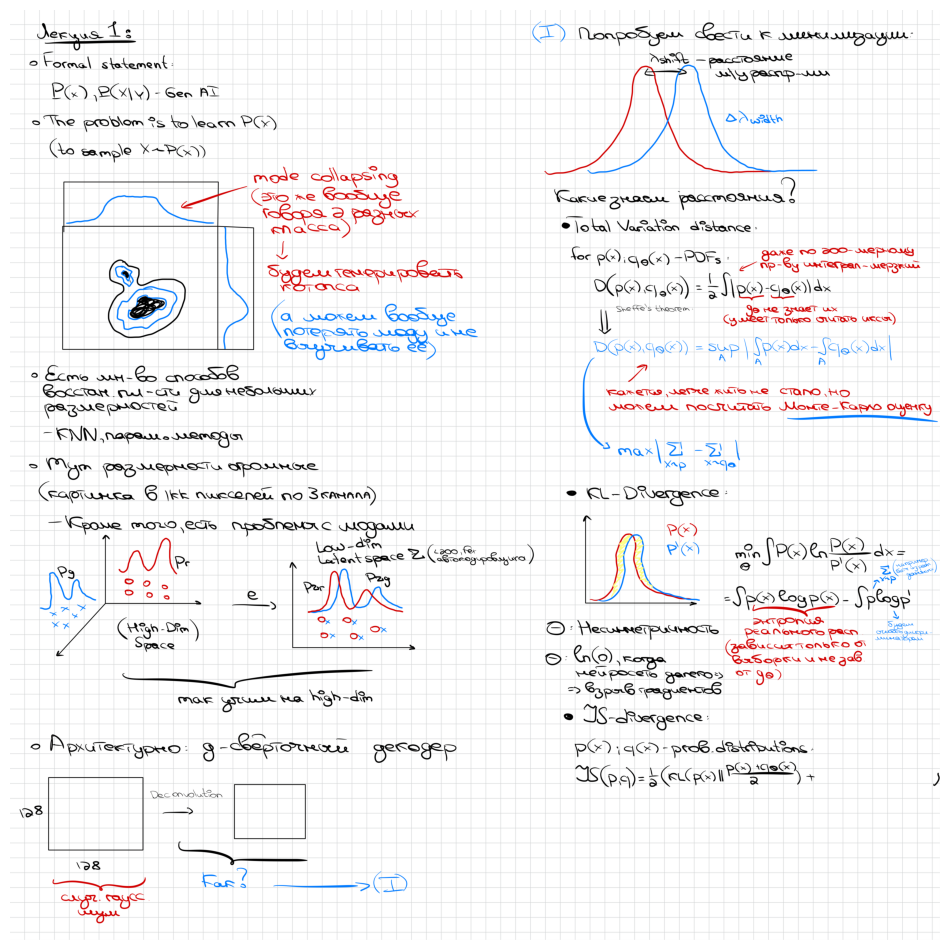

Page 2: 64 text blocks
{'type': 'text', 'lang': 'ru', 'bbox': [293, 12, 568, 33]} Не сможем свести F  ...
{'type': 'text', 'lang': 'ru', 'bbox': [269, 15, 939, 56]} оЭто нисточное, ĸаĸ ЕМ-апгоритм 7 ĸ батчалтвведем  ...
{'type': 'text', 'lang': 'ru', 'bbox': [325, 52, 865, 120]} другую Критерии ĸачествоя J оПравдоподобие. Prechston  ...


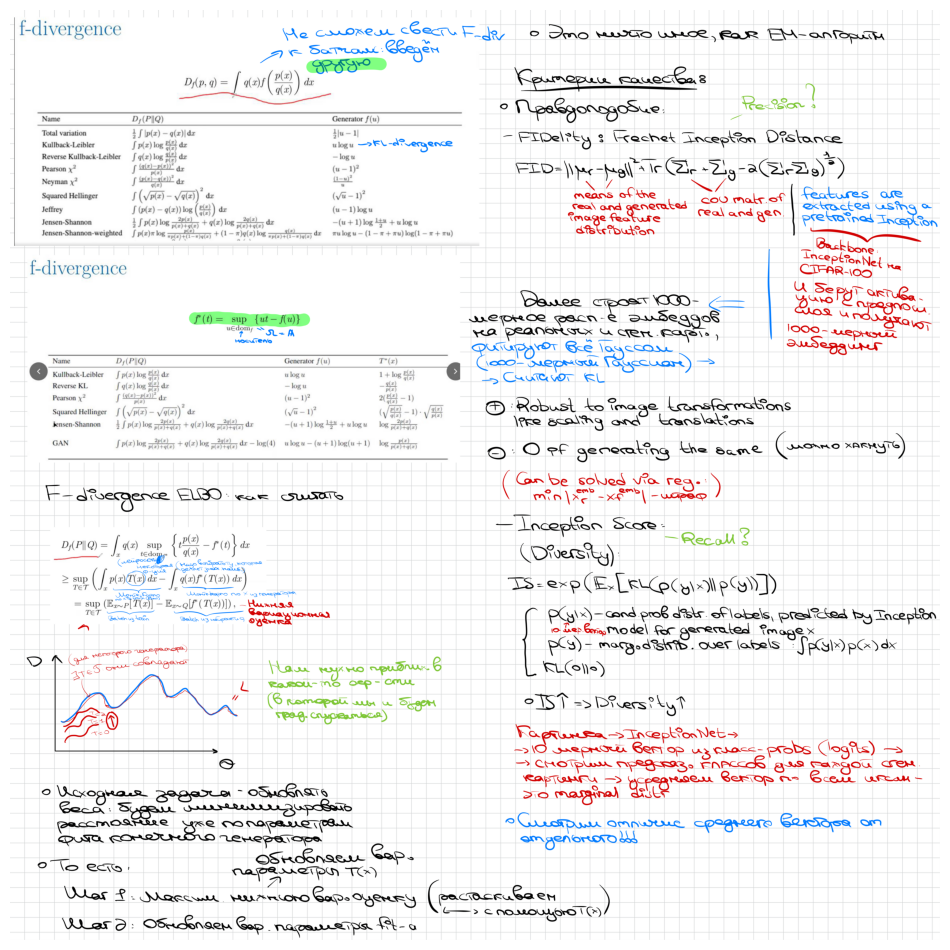

Page 3: 53 text blocks
{'type': 'text', 'lang': 'ca', 'bbox': [8, 30, 39, 44]} L r  ...
{'type': 'text', 'lang': '', 'bbox': [32, 48, 37, 48]} -  ...
{'type': 'text', 'lang': 'bg', 'bbox': [63, 88, 264, 124]} РСУ-центроид O Xr ĸластера ООФ  ...


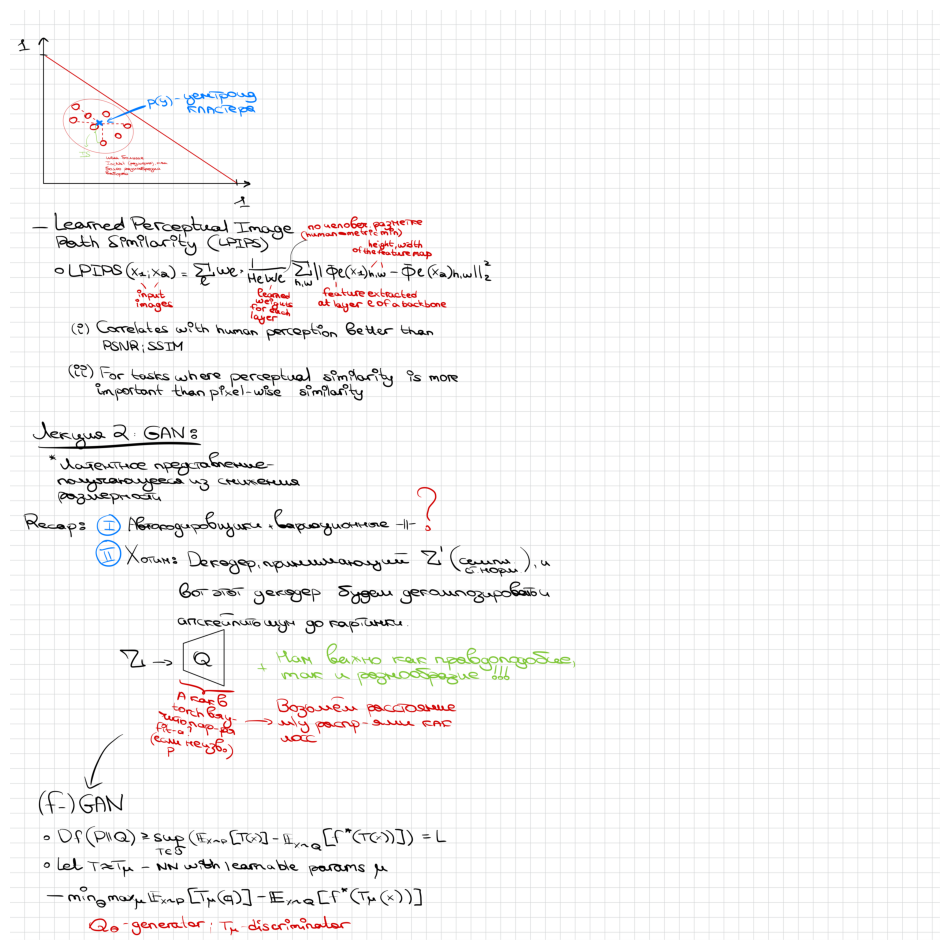

In [27]:
def process_pdf(path: str):
    print(f"\n=== {os.path.basename(path)} ===")
    info = classify_pdf(path)
    print(json.dumps(info, ensure_ascii=False, indent=2))
    doc = fitz.open(path)
    pages_to_run = min(MAX_PAGES, len(doc))
    for i in range(pages_to_run):
        page = doc[i]
        if info["kind"] == "text_pdf":
            unified = unify_text_pdf_page(page)
            # Preview: show up to 3 text blocks
            print(f"Page {i+1}: {len(unified['blocks'])} text blocks")
            for b in unified['blocks'][:3]:
                print({k: b[k] for k in ('type','lang','bbox')}, b['text'][:120].replace('\n',' '), '...')
            page_unified_preview(unified)
        else:
            unified = unify_scanned_like_page(page)
            print(f"Page {i+1}: {len(unified['words'])} OCR words; highlights: {list((unified['highlights'].get('masks') or {}).keys())}")
            # Show sample words
            for w in unified['words'][:10]:
                print(w['text'], w['bbox'], f"conf={w['conf']:.1f}")
            page_unified_preview(unified)

if not PDF_PATHS:
    print("Please set PDF_PATHS to 3 file paths and re-run.")
else:
    for p in PDF_PATHS:
        assert os.path.exists(p), f"File not found: {p}"
    for p in PDF_PATHS:
        process_pdf(p)



## Improvements: script-aware language, OCR pre-processing, bbox overlays

- Script-aware language tagging for text blocks (`ru`, `en`, `ru+en`).
- OCR pre-processing: LAB-CLAHE → denoise → adaptive threshold → upscaling.
- Tesseract config + fallback PSM if weak results.
- Unified visualization draws text-block boxes (blue) and OCR words (red).


In [28]:
def detect_script_label(text: str) -> str:
    # Simple script detection using Unicode ranges
    has_cyr = any('а' <= ch <= 'я' or 'А' <= ch <= 'Я' for ch in text)
    has_lat = any('a' <= ch <= 'z' or 'A' <= ch <= 'Z' for ch in text)
    if has_cyr and has_lat:
        return 'ru+en'
    if has_cyr:
        return 'ru'
    if has_lat:
        return 'en'
    return ''


def preprocess_for_ocr(img: Image.Image, upscale: float = 1.5) -> Image.Image:
    rgb = np.array(ensure_rgb(img))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    # Upscale for better small text
    if upscale and upscale != 1.0:
        bgr = cv2.resize(bgr, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_CUBIC)
    # Convert to LAB and apply CLAHE on L-channel
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    # Denoise
    bgr2 = cv2.fastNlMeansDenoisingColored(bgr2, None, 3, 3, 7, 21)
    # Grayscale + adaptive threshold
    gray = cv2.cvtColor(bgr2, cv2.COLOR_BGR2GRAY)
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY, 31, 15)
    # Invert if background dark
    if np.mean(th) < 127:
        th = 255 - th
    return Image.fromarray(cv2.cvtColor(th, cv2.COLOR_GRAY2RGB))


def ocr_tesseract_improved(img: Image.Image, lang: str = "rus+eng") -> List[Dict[str, Any]]:
    if pytesseract is None:
        return []
    # Preprocess
    pre = preprocess_for_ocr(img)
    config_primary = "--oem 3 --psm 6"
    data = pytesseract.image_to_data(pre, lang=lang, config=config_primary, output_type=pytesseract.Output.DICT)
    words = []
    def collect(d):
        n = len(d["text"]) if d and "text" in d else 0
        for i in range(n):
            text = (d["text"][i] or "").strip()
            if not text:
                continue
            x, y, w, h = d["left"][i], d["top"][i], d["width"][i], d["height"][i]
            conf = float(d.get("conf", ["-1"][0])[i]) if d.get("conf") else -1.0
            words.append({
                "text": text,
                "bbox": [int(x), int(y), int(x+w), int(y+h)],
                "conf": conf,
                "engine": "tesseract_pre",
            })
    collect(data)
    # Fallback if weak
    if len(words) < 10:
        config_fallback = "--oem 3 --psm 4"
        data2 = pytesseract.image_to_data(pre, lang=lang, config=config_fallback, output_type=pytesseract.Output.DICT)
        collect(data2)
    return words


def run_ocr(img: Image.Image, lang: str = "rus+eng") -> List[Dict[str, Any]]:
    if pytesseract is not None:
        return ocr_tesseract_improved(img, lang=lang)
    lang_map = {"eng": ["en"], "rus": ["ru"], "rus+eng": ["ru", "en"]}
    langs = lang_map.get(lang, ["en"])
    return ocr_easyocr(img, langs)

# Override text-PDF block language tagging
def extract_text_blocks(page: fitz.Page) -> List[Dict[str, Any]]:
    blocks = page.get_text("blocks") or []
    out = []
    for b in blocks:
        if len(b) < 5:
            continue
        x0, y0, x1, y1, text = b[:5]
        if not (text or "").strip():
            continue
        script = detect_script_label(text)
        out.append({
            "type": "text",
            "text": text,
            "bbox": [int(x0), int(y0), int(x1), int(y1)],
            "lang": script,
            "source": "pymupdf_blocks",
        })
    return out



In [29]:
# Enhanced visualization: draw text blocks (blue) and OCR words (red), highlights

def page_unified_preview(unified: Dict[str, Any]):
    img = unified["image"]
    words = unified.get("words", [])
    highlights = unified.get("highlights", {})
    blocks = unified.get("blocks", [])

    fig = plt.figure(figsize=SHOW_FIGSIZE)
    plt.imshow(img)
    ax = plt.gca()

    # Text blocks (blue)
    for b in blocks:
        if b.get("type") == "text":
            x0,y0,x1,y1 = b["bbox"]
            rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='cyan', linewidth=1.5)
            ax.add_patch(rect)

    # Words (red)
    for w in words:
        x0,y0,x1,y1 = w["bbox"]
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=1)
        ax.add_patch(rect)

    # Highlights
    for cname, mask in (highlights.get("masks") or {}).items():
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < 200:
                continue
            rect = plt.Rectangle((x,y), w, h, fill=False, edgecolor='yellow' if cname=="yellow" else ('green' if cname=="green" else 'magenta'), linewidth=2)
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()

# Additionally, print bounding boxes explicitly for debugging

def print_bboxes(unified: Dict[str, Any], max_items: int = 20):
    print("Text blocks (up to N):")
    cnt = 0
    for b in unified.get("blocks", []):
        if b.get("type") == "text":
            print("[BLOCK]", b.get("lang"), b.get("bbox"), (b.get("text") or "").strip()[:100])
            cnt += 1
            if cnt >= max_items:
                break
    print("OCR words (up to N):")
    for w in unified.get("words", [])[:max_items]:
        print("[WORD]", w.get("bbox"), w.get("text"), f"conf={w.get('conf',-1):.1f}")




=== Lectures.pdf ===
{
  "kind": "text_pdf",
  "avg_text_density": 0.001326,
  "goodnotes_hint": false,
  "meta": {
    "producer": "ios version 17.5.1 (build 21f91) quartz pdfcontext",
    "creator": "",
    "title": ""
  },
  "num_pages": 15
}
Page 1: 69 text blocks
Text blocks (up to N):
[BLOCK] ru [29, 12, 970, 42] 1еĸциа1о
С#) Хопробуо свестиĸминилизации
[BLOCK] en [21, 45, 175, 63] oFormal
suetement
[BLOCK] en [688, 45, 839, 63] Asht
[BLOCK] en [682, 63, 727, 70] E
[BLOCK] ru [758, 62, 880, 78] Мружаспр-ми
[BLOCK] en [45, 78, 57, 94] PCx
[BLOCK] en [45, 79, 211, 98] RCX
[BLOCK] en [24, 81, 225, 131] Gen
AI
oThe
[BLOCK] en [115, 114, 129, 124] problom
[BLOCK] en [130, 113, 286, 128] to learnPCX
[BLOCK] ru [42, 59, 868, 176] н
(
[BLOCK] en [109, 143, 209, 164] sample XuPCX
[BLOCK] en [262, 168, 417, 191] modecollapsiing
[BLOCK] ru+en [60, 180, 843, 243] r
ССэто же
гаĸиезнаем расстояния?
r
говоряэĸазных
knacca
[BLOCK] en [593, 222, 792, 239] o
[BLOCK] en [801, 233, 803, 235] Vartat

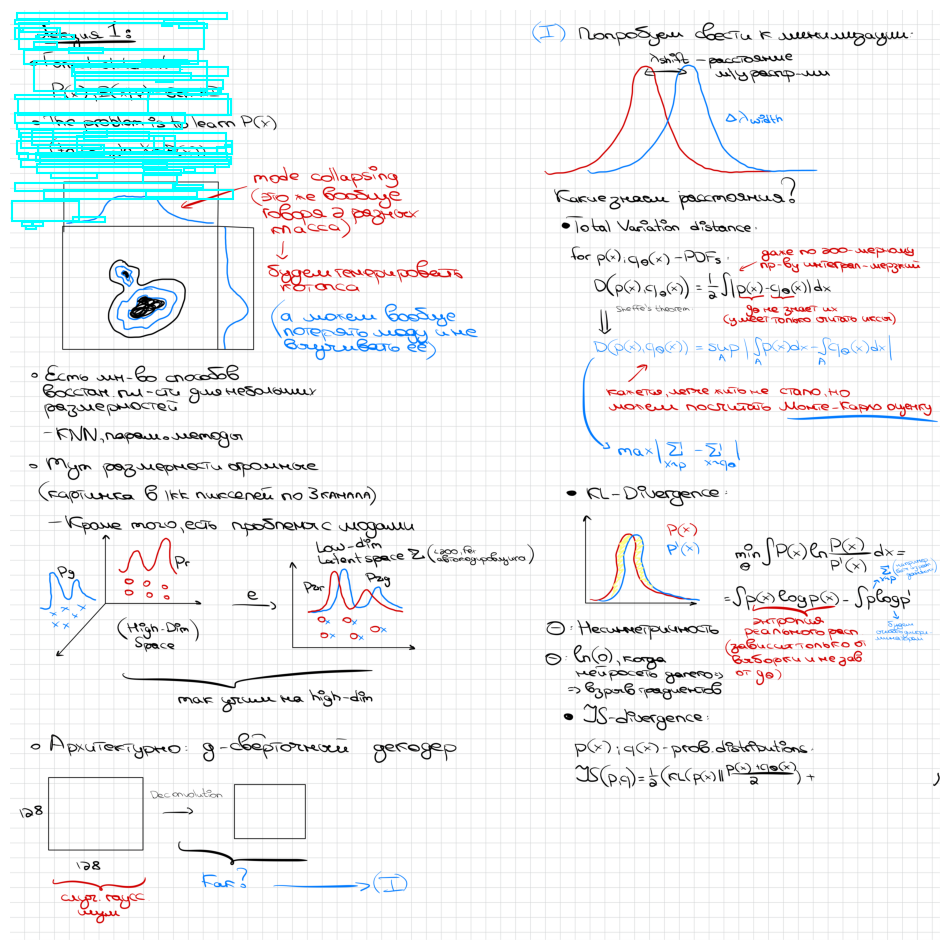

Page 2: 64 text blocks
Text blocks (up to N):
[BLOCK] ru+en [293, 12, 568, 33] Не сможем свести
F
[BLOCK] ru [269, 15, 939, 56] оЭто нисточное, ĸаĸ ЕМ-апгоритм
7 ĸ батчалтвведем
[BLOCK] ru+en [325, 52, 865, 120] другую
Критерии ĸачествоя
J
оПравдоподобие.
Prechston
[BLOCK] en [374, 114, 782, 152] r
-4
[BLOCK] en [530, 130, 623, 149] -EIDelity
[BLOCK] en [544, 128, 893, 183] FrechetInceptionDestance
FID
[BLOCK] en [805, 159, 857, 179] Er
[BLOCK] en [619, 152, 896, 194] ?)
V
y
[BLOCK] en [606, 190, 694, 202] means otthe
[BLOCK] en [605, 190, 988, 221] coumatrof featuresare
ted
a
real
[BLOCK] en [600, 181, 974, 241] andgenera
realand
extracted using
emagefeature
gen l Pretra
[BLOCK] en [896, 217, 995, 235] nc
[BLOCK] en [609, 231, 977, 262] destrpbutton
r
Z
[BLOCK] ru+en [493, 257, 989, 351] T
EFRбена
u берутаĸтива
Далее строятВОО-Ет
цию спредпом
Слоя
ЧПО
шерное жаспе эмбеддов
l
[BLOCK] ru [242, 327, 990, 357] 10
лумают
"Ч=А
нареапьных и стен-ĸарто,
оо-мерный
Моситель
[BLOCK] ru [496, 348

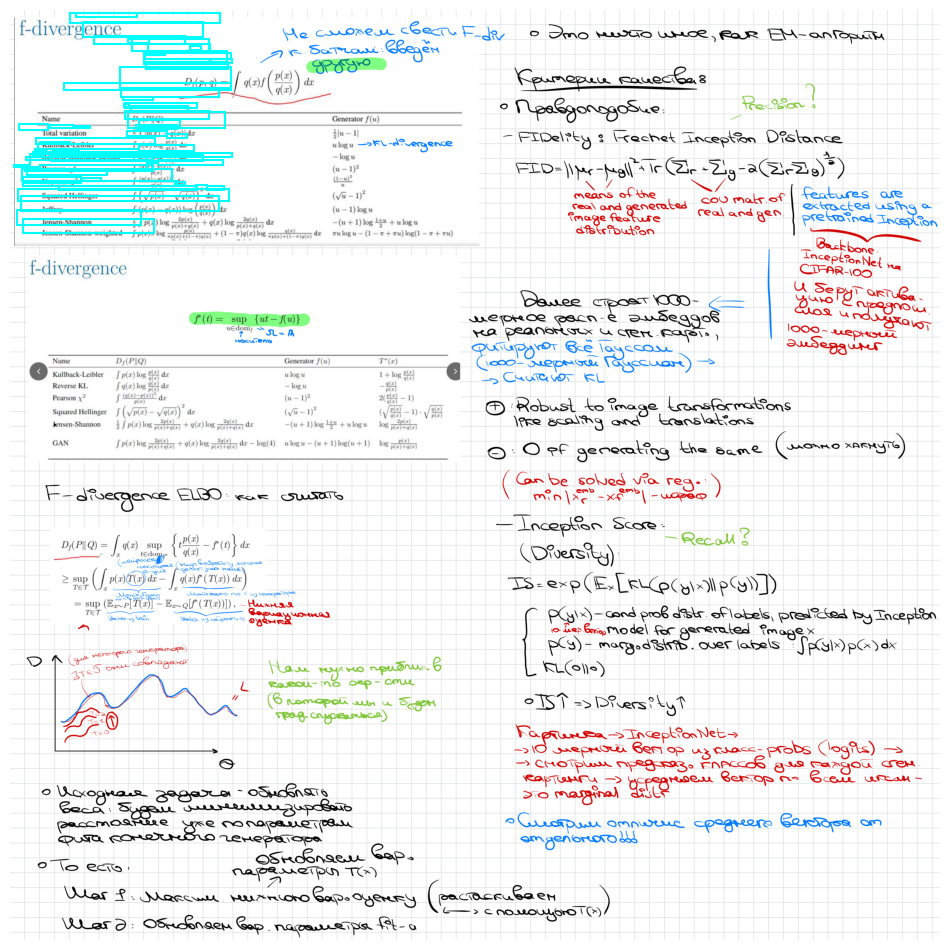

Page 3: 53 text blocks
Text blocks (up to N):
[BLOCK] en [8, 30, 39, 44] L
r
[BLOCK]  [32, 48, 37, 48] -
[BLOCK] ru+en [63, 88, 264, 124] РСУ-центроид
O Xr
ĸластера
ООФ
[BLOCK] ru [86, 118, 119, 142] Фо
[BLOCK] en [121, 121, 129, 127] O
[BLOCK] en [74, 133, 103, 158] X
O
I
[BLOCK] ru+en [102, 156, 168, 167] Шелл больше
rue
ImaNet (разлерто), me
[BLOCK] ru [102, 167, 258, 190] болеа разнообразĸа
выборĸа
1
[BLOCK] en [241, 201, 257, 212] L
[BLOCK] ru+en [24, 218, 305, 246] - ' LearnedPerces
-таде
[BLOCK] ru+en [185, 222, 443, 247] почело вет разнетĸе.
otualT
(
[BLOCK] en [362, 234, 421, 243] metrec
[BLOCK] en [49, 241, 277, 263] aath
smlarty(
[BLOCK] en [386, 247, 433, 257] height
[BLOCK] en [293, 247, 442, 282] width
r
[BLOCK] en [368, 254, 455, 267] oxfthe-
[BLOCK] en [48, 271, 189, 290] OLP
[BLOCK]  [197, 267, 294, 295] (
[BLOCK] ru [302, 269, 402, 297] ещ
[BLOCK] ru+en [140, 264, 517, 299] Дй ĸотесхвий-эегха)шĸ(?
I
OCR words (up to N):


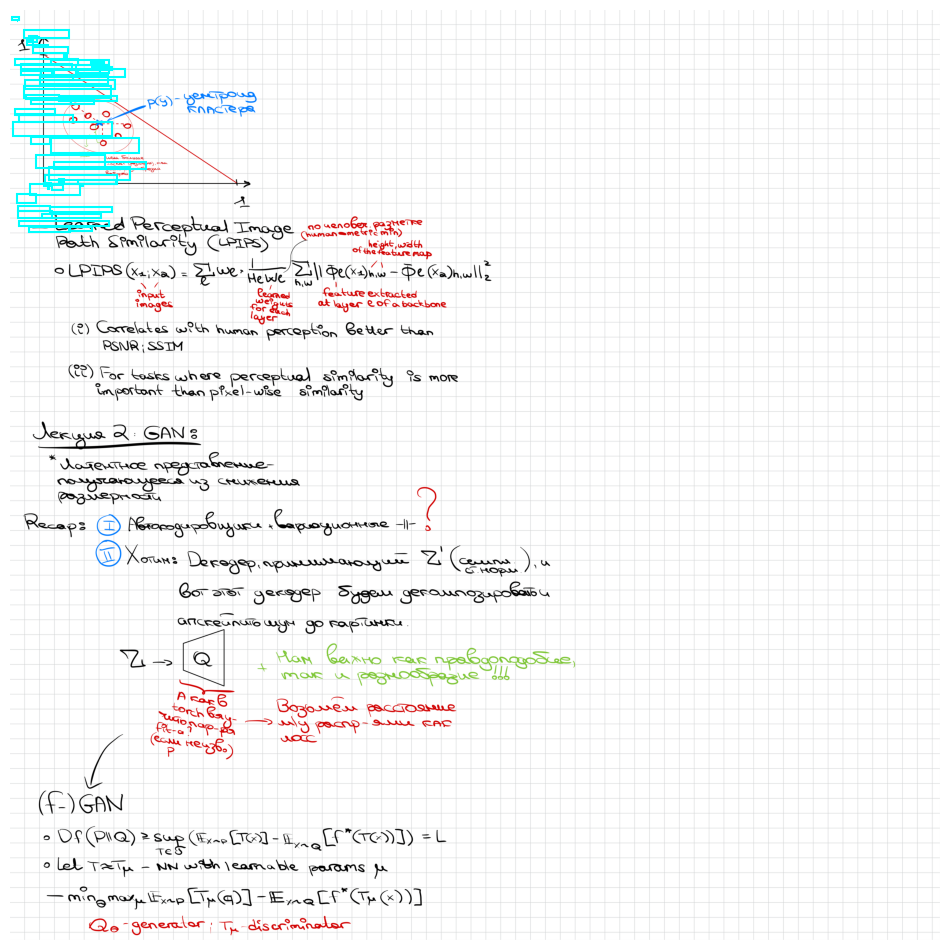

In [30]:
# Hook bbox printing into process flow

def process_pdf(path: str):
    print(f"\n=== {os.path.basename(path)} ===")
    info = classify_pdf(path)
    print(json.dumps(info, ensure_ascii=False, indent=2))
    doc = fitz.open(path)
    pages_to_run = min(MAX_PAGES, len(doc))
    for i in range(pages_to_run):
        page = doc[i]
        if info["kind"] == "text_pdf":
            unified = unify_text_pdf_page(page)
            print(f"Page {i+1}: {len(unified['blocks'])} text blocks")
            print_bboxes(unified, max_items=20)
            page_unified_preview(unified)
        else:
            unified = unify_scanned_like_page(page)
            print(f"Page {i+1}: {len(unified['words'])} OCR words; highlights: {list((unified['highlights'].get('masks') or {}).keys())}")
            print_bboxes(unified, max_items=30)
            page_unified_preview(unified)

if not PDF_PATHS:
    print("Please set PDF_PATHS to 3 file paths and re-run.")
else:
    for p in PDF_PATHS:
        assert os.path.exists(p), f"File not found: {p}"
    for p in PDF_PATHS:
        process_pdf(p)



## Advanced region proposals and grouping (for GoodNotes/scanned)

We add:
- Binary maps for printed vs. handwriting-like strokes
- Region proposals via morphology + contours (+ MSER-like effect)
- NMS and merging to avoid 50 small boxes
- Group OCR words into lines
- Optional TrOCR for handwriting if Tesseract fails


In [31]:
def binarize_strokes(img: Image.Image) -> Dict[str, np.ndarray]:
    rgb = np.array(ensure_rgb(img))
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    # Emphasize strokes via morphological blackhat
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    # Otsu threshold
    _, th = cv2.threshold(blackhat, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Printed text tends to be thinner; handwriting thick/curvy
    thin = cv2.ximgproc.thinning(th) if hasattr(cv2, 'ximgproc') else th
    return {"thin": thin, "bin": th}


def propose_regions(img: Image.Image) -> List[List[int]]:
    rgb = np.array(ensure_rgb(img))
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    # Adaptive threshold to handle graph paper background
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                               cv2.THRESH_BINARY_INV, 31, 15)
    # Close to merge characters and lines
    kernel = np.ones((7,7), np.uint8)
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kernel, iterations=2)
    # Remove small noise
    kernel2 = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel2)
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []
    h, w = opened.shape
    area_min = (w*h) * 0.0002
    for c in contours:
        x,y,ww,hh = cv2.boundingRect(c)
        if ww*hh < area_min:
            continue
        # aspect / size filters to reduce tiny fragments
        if hh < 12 or ww < 12:
            continue
        boxes.append([x, y, x+ww, y+hh])
    return boxes


def nms_merge(boxes: List[List[int]], iou_thresh: float = 0.2) -> List[List[int]]:
    if not boxes:
        return []
    boxes = np.array(boxes, dtype=np.float32)
    x1, y1, x2, y2 = boxes[:,0], boxes[:,1], boxes[:,2], boxes[:,3]
    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = np.argsort(areas)[::-1]
    keep = []
    while order.size > 0:
        i = order[0]
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])
        w = np.maximum(0.0, xx2 - xx1 + 1)
        h = np.maximum(0.0, yy2 - yy1 + 1)
        inter = w * h
        iou = inter / (areas[i] + areas[order[1:]] - inter + 1e-6)
        inds = np.where(iou <= iou_thresh)[0]
        order = order[inds + 1]
    merged = boxes[keep].astype(int).tolist()
    return merged


def group_words_into_lines(words: List[Dict[str, Any]], y_tol: int = 10) -> List[Dict[str, Any]]:
    if not words:
        return []
    # sort by y, then x
    words_sorted = sorted(words, key=lambda w: (w['bbox'][1], w['bbox'][0]))
    lines = []
    current = []
    last_y = None
    for w in words_sorted:
        y = w['bbox'][1]
        if last_y is None or abs(y - last_y) <= y_tol:
            current.append(w)
            last_y = y if last_y is None else (last_y + y)//2
        else:
            lines.append(current)
            current = [w]
            last_y = y
    if current:
        lines.append(current)
    # Merge line boxes and text
    line_objs = []
    for line in lines:
        xs0 = [w['bbox'][0] for w in line]
        ys0 = [w['bbox'][1] for w in line]
        xs1 = [w['bbox'][2] for w in line]
        ys1 = [w['bbox'][3] for w in line]
        bbox = [min(xs0), min(ys0), max(xs1), max(ys1)]
        text = ' '.join(w['text'] for w in line)
        conf = float(np.mean([w.get('conf', 0) for w in line]))
        line_objs.append({"text": text, "bbox": bbox, "conf": conf, "type": "ocr_line"})
    return line_objs



In [32]:
# Integrate proposals and grouping into scanned/GN path

def unify_scanned_like_page(page: fitz.Page) -> Dict[str, Any]:
    img = page_to_image(page, dpi=RASTER_DPI)
    # Region proposals to avoid many tiny boxes
    props = propose_regions(img)
    props = nms_merge(props, iou_thresh=0.15)
    # OCR full page first, then group into lines
    words = run_ocr(img, lang=OCR_LANG)
    lines = group_words_into_lines(words, y_tol=14)
    hl = detect_highlights(img)
    return {
        "image": img,
        "blocks": lines,  # treat lines as blocks for now
        "words": words,
        "regions": props,
        "highlights": hl,
        "kind": "scanned_or_gn",
    }



In [33]:
# Visualize proposed regions in addition to words/blocks

def page_unified_preview(unified: Dict[str, Any]):
    img = unified["image"]
    words = unified.get("words", [])
    highlights = unified.get("highlights", {})
    blocks = unified.get("blocks", [])
    regions = unified.get("regions", [])

    fig = plt.figure(figsize=SHOW_FIGSIZE)
    plt.imshow(img)
    ax = plt.gca()

    # Proposed regions (purple)
    for x0,y0,x1,y1 in regions:
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='purple', linewidth=1.5, linestyle='--')
        ax.add_patch(rect)

    # Text blocks / lines (blue)
    for b in blocks:
        bb = b["bbox"] if isinstance(b, dict) else b
        x0,y0,x1,y1 = bb
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='cyan', linewidth=1.5)
        ax.add_patch(rect)

    # Words (red)
    for w in words:
        x0,y0,x1,y1 = w["bbox"]
        rect = plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=0.8)
        ax.add_patch(rect)

    # Highlights
    for cname, mask in (highlights.get("masks") or {}).items():
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for c in contours:
            x, y, w, h = cv2.boundingRect(c)
            if w*h < 200:
                continue
            rect = plt.Rectangle((x,y), w, h, fill=False, edgecolor='yellow' if cname=="yellow" else ('green' if cname=="green" else 'magenta'), linewidth=2)
            ax.add_patch(rect)

    plt.axis('off')
    plt.show()



In [34]:
# Interactive OCR tuning panel (append-only)
try:
    import ipywidgets as W
    from IPython.display import display, clear_output
    W_OK = True
except Exception:
    W_OK = False

if not W_OK:
    print("ipywidgets not available; install ipywidgets to use the interactive panel.")
else:
    # Controls
    path_w = W.Text(value=(PDF_PATHS[0] if PDF_PATHS else ''), description='PDF Path', layout=W.Layout(width='70%'))
    page_w = W.IntText(value=0, description='Page')
    mode_w = W.Dropdown(options=[('auto','auto'),('force text','text_pdf'),('force scanned/GN','scanned')], value='auto', description='Mode')

    dpi_w = W.IntSlider(value=RASTER_DPI if 'RASTER_DPI' in globals() else 400, min=200, max=600, step=25, description='DPI')
    upscale_w = W.FloatSlider(value=2.0, min=1.0, max=3.0, step=0.1, description='Upscale')
    oem_w = W.Dropdown(options=[1,3], value=3, description='OEM')
    psm_w = W.Dropdown(options=[3,6,7,11], value=11, description='PSM')

    bs_w = W.IntSlider(value=41, min=21, max=101, step=2, description='BlkSize')
    c_w = W.IntSlider(value=12, min=0, max=25, step=1, description='C')
    close_w = W.IntSlider(value=9, min=3, max=17, step=2, description='CloseK')
    closei_w = W.IntSlider(value=2, min=1, max=4, step=1, description='CloseIt')
    open_w = W.IntSlider(value=3, min=1, max=11, step=2, description='OpenK')
    openi_w = W.IntSlider(value=1, min=0, max=3, step=1, description='OpenIt')
    area_w = W.FloatSlider(value=0.0002, min=0.00005, max=0.001, step=0.00005, readout_format='.5f', description='AreaMin')
    iou_w = W.FloatSlider(value=0.30, min=0.05, max=0.5, step=0.05, description='NMS IoU')

    conf_w = W.IntSlider(value=55 if 'WORD_CONF_MIN' in globals() else 45, min=0, max=95, step=5, description='ConfMin')
    ytol_w = W.IntSlider(value=18, min=4, max=32, step=2, description='Y tol')

    btn = W.Button(description='Run preview', button_style='primary')
    out = W.Output()

    PREV = {}

    def page_to_image_dpi(page, dpi):
        mat = fitz.Matrix(dpi/72, dpi/72)
        pix = page.get_pixmap(matrix=mat, alpha=False)
        return Image.frombytes('RGB', [pix.width, pix.height], pix.samples)

    def preprocess_for_ocr_param(img, upscale, blockSize, C):
        rgb = np.array(img.convert('RGB'))
        bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
        scale = 1.0
        if upscale and upscale != 1.0:
            bgr = cv2.resize(bgr, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_CUBIC)
            scale *= float(upscale)
        lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        l2 = clahe.apply(l)
        lab2 = cv2.merge((l2, a, b))
        bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
        bgr2 = cv2.fastNlMeansDenoisingColored(bgr2, None, 3, 3, 7, 21)
        gray = cv2.cvtColor(bgr2, cv2.COLOR_BGR2GRAY)
        th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, int(blockSize)|1, int(C))
        if np.mean(th) < 127:
            th = 255 - th
        return Image.fromarray(cv2.cvtColor(th, cv2.COLOR_GRAY2RGB)), scale

    def ocr_tesseract_param(img, lang, oem, psm, upscale, blockSize, C):
        if 'pytesseract' not in globals() or pytesseract is None:
            return []
        pre, scale = preprocess_for_ocr_param(img, upscale, blockSize, C)
        cfg = f"--oem {int(oem)} --psm {int(psm)}"
        d = pytesseract.image_to_data(pre, lang=lang, config=cfg, output_type=pytesseract.Output.DICT)
        words = []
        n = len(d.get('text', []))
        for i in range(n):
            text = (d['text'][i] or '').strip()
            if not text:
                continue
            x, y, w, h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
            conf = float(d.get('conf', ['-1'])[i]) if d.get('conf') else -1.0
            x0, y0, x1, y1 = int(x/scale), int(y/scale), int((x+w)/scale), int((y+h)/scale)
            words.append({'text': text, 'bbox': [x0,y0,x1,y1], 'conf': conf, 'engine': 'tesseract'})
        return words

    def propose_regions_param(img, blockSize, C, k_close, it_close, k_open, it_open, area_min_frac, nms_iou):
        gray = cv2.cvtColor(np.array(img.convert('RGB')), cv2.COLOR_RGB2GRAY)
        th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, int(blockSize)|1, int(C))
        kc = np.ones((int(k_close), int(k_close)), np.uint8)
        ko = np.ones((int(k_open), int(k_open)), np.uint8)
        closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kc, iterations=int(it_close))
        opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, ko, iterations=int(it_open))
        contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        h, w = opened.shape
        area_min = (w*h) * float(area_min_frac)
        boxes = []
        for c in contours:
            x,y,ww,hh = cv2.boundingRect(c)
            if ww*hh < area_min or hh < 12 or ww < 12:
                continue
            boxes.append([x, y, x+ww, y+hh])
        # Use existing nms if available
        try:
            merged = nms_merge(boxes, float(nms_iou))
        except Exception:
            merged = boxes
        return merged

    def group_lines(words, y_tol):
        try:
            return group_words_into_lines(words, y_tol=int(y_tol))
        except Exception:
            # Fallback simple grouping
            ws = sorted(words, key=lambda w: (w['bbox'][1], w['bbox'][0]))
            lines, cur, last_y = [], [], None
            for w in ws:
                y = w['bbox'][1]
                if last_y is None or abs(y - last_y) <= int(y_tol):
                    cur.append(w); last_y = y if last_y is None else (last_y + y)//2
                else:
                    lines.append(cur); cur = [w]; last_y = y
            if cur: lines.append(cur)
            out = []
            for line in lines:
                xs0 = [w['bbox'][0] for w in line]; ys0 = [w['bbox'][1] for w in line]
                xs1 = [w['bbox'][2] for w in line]; ys1 = [w['bbox'][3] for w in line]
                bbox = [min(xs0), min(ys0), max(xs1), max(ys1)]
                text = ' '.join(w['text'] for w in line); conf = float(np.mean([w.get('conf',0) for w in line]))
                out.append({'text': text, 'bbox': bbox, 'conf': conf, 'type': 'ocr_line'})
            return out

    def unify_text_param(page, dpi):
        img = page_to_image_dpi(page, dpi)
        # Use existing text blocks and scale from PDF points to pixels
        blocks = extract_text_blocks(page)
        scale = dpi / 72.0
        scaled = []
        for b in blocks:
            x0,y0,x1,y1 = b['bbox']
            xb = [int(round(x0*scale)), int(round(y0*scale)), int(round(x1*scale)), int(round(y1*scale))]
            nb = dict(b); nb['bbox'] = xb; scaled.append(nb)
        return {'image': img, 'blocks': scaled, 'words': [], 'regions': [], 'highlights': {}, 'kind': 'text_pdf'}

    def unify_scanned_param(page, dpi, lang, oem, psm, upscale, bs, C, kclose, iclose, kopen, iopen, area_frac, nms_iou, y_tol):
        img = page_to_image_dpi(page, dpi)
        props = propose_regions_param(img, bs, C, kclose, iclose, kopen, iopen, area_frac, nms_iou)
        words = ocr_tesseract_param(img, lang, oem, psm, upscale, bs, C)
        lines = group_lines(words, y_tol)
        return {'image': img, 'blocks': lines, 'words': words, 'regions': props, 'highlights': {}, 'kind': 'scanned_or_gn'}

    def draw(ax, uni, conf_min, draw_limit=600):
        ax.imshow(uni['image'])
        for bb in uni.get('regions', []):
            x0,y0,x1,y1 = bb
            ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='purple', linewidth=1.2, linestyle='--'))
        for b in uni.get('blocks', []):
            bb = b['bbox'] if isinstance(b, dict) else b
            x0,y0,x1,y1 = bb
            ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='cyan', linewidth=1.2))
        words = [w for w in uni.get('words', []) if w.get('conf', 100) >= int(conf_min)]
        for w in words[:int(draw_limit)]:
            x0,y0,x1,y1 = w['bbox']
            ax.add_patch(plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=0.8))
        ax.axis('off')

    def stats(uni):
        return {'words': len(uni.get('words', [])), 'blocks': len(uni.get('blocks', [])), 'regions': len(uni.get('regions', []))}

    def on_click(_):
        with out:
            clear_output(wait=True)
            try:
                doc = fitz.open(path_w.value)
            except Exception as e:
                print('Open error:', e); return
            page_idx = int(page_w.value)
            if page_idx < 0 or page_idx >= len(doc):
                print('Page out of range:', page_idx, 'pages:', len(doc)); return
            page = doc[page_idx]
            key = (path_w.value, page_idx)
            prev = PREV.get(key)
            print('Running...')
            t0 = __import__('time').time()
            if mode_w.value == 'text_pdf':
                uni = unify_text_param(page, int(dpi_w.value))
            elif mode_w.value == 'scanned':
                uni = unify_scanned_param(page, int(dpi_w.value), 'rus+eng', int(oem_w.value), int(psm_w.value), float(upscale_w.value), int(bs_w.value), int(c_w.value), int(close_w.value), int(closei_w.value), int(open_w.value), int(openi_w.value), float(area_w.value), float(iou_w.value), int(ytol_w.value))
            else:
                # auto classify using existing function
                info = classify_pdf(path_w.value)
                if info['kind'] == 'text_pdf':
                    uni = unify_text_param(page, int(dpi_w.value))
                else:
                    uni = unify_scanned_param(page, int(dpi_w.value), 'rus+eng', int(oem_w.value), int(psm_w.value), float(upscale_w.value), int(bs_w.value), int(c_w.value), int(close_w.value), int(closei_w.value), int(open_w.value), int(openi_w.value), float(area_w.value), float(iou_w.value), int(ytol_w.value))
            t1 = __import__('time').time()
            print('Time:', f"{t1-t0:.2f}s")
            fig, axes = plt.subplots(1, 2 if prev else 1, figsize=(14 if prev else 7, 10))
            if prev:
                axes = np.array(axes).reshape(-1)
                axes[0].set_title('Before')
                draw(axes[0], prev['uni'], conf_min=prev.get('conf_min', conf_w.value))
                axes[1].set_title('After')
                draw(axes[1], uni, conf_min=conf_w.value)
            else:
                if not isinstance(axes, np.ndarray):
                    axes = np.array([axes])
                axes[0].set_title('Current')
                draw(axes[0], uni, conf_min=conf_w.value)
            plt.show()
            new_s = stats(uni)
            if prev:
                old_s = prev['stats']
                print('Metric changes:')
                for k in ['words','blocks','regions']:
                    print(f" - {k}: {old_s.get(k,0)} -> {new_s.get(k,0)}")
            else:
                print('Metrics:', new_s)
            PREV[key] = {'uni': uni, 'stats': new_s, 'conf_min': int(conf_w.value)}

    btn.on_click(on_click)
    panel = W.VBox([
        W.HBox([path_w, page_w, mode_w]),
        W.HBox([dpi_w, upscale_w, oem_w, psm_w]),
        W.HBox([bs_w, c_w, close_w, closei_w]),
        W.HBox([open_w, openi_w, area_w, iou_w]),
        W.HBox([conf_w, ytol_w, btn]),
        out
    ])
    display(panel)
    print("Set params and click Run preview; Before vs After will be shown with metric deltas.")


Set params and click Run preview; Before vs After will be shown with metric deltas.


In [ ]:
# Batch OCR sweep: generate many variations and save artifacts (images + JSON + CSV)
import os, json, csv, random, datetime
from typing import Dict, Any, List

# Inputs
SWEEP_DOCS = [
    "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/Generative ML/Lectures.pdf",
    "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/Machine Learning/Lectures.pdf",
    "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/Deep Learning/Lectures.pdf",
    "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/Optimization in ML/Lectures.pdf",
]
TOTAL_IMAGES_TARGET = 20   # number of distinct pages to sample across docs
MAX_RUNS = 120             # max param configurations to evaluate
OUT_ROOT = "/Users/aeshef/Desktop/CAREER & STUDIES/ВШЭ/study_kb/ocr_sweeps"

# Parameter search space (adjust as needed)
SPACE = {
    "dpi": [300, 400, 450],
    "upscale": [1.5, 2.0, 2.5],
    "oem": [1, 3],
    "psm": [6, 11, 3],
    "blk": [31, 41, 61, 81],
    "C": [8, 12, 16],
    "closek": [7, 9, 11, 13],
    "closeit": [1, 2],
    "openk": [3, 5, 7],
    "openit": [0, 1],
    "area": [0.0002, 0.0004, 0.0006],
    "nms": [0.2, 0.3, 0.35],
    "ytol": [12, 18, 22],
}

# Utilities (force OCR path regardless of text PDF)
def page_to_image_dpi(page, dpi):
    mat = fitz.Matrix(dpi/72, dpi/72)
    pix = page.get_pixmap(matrix=mat, alpha=False)
    return Image.frombytes('RGB', [pix.width, pix.height], pix.samples)

def preprocess_for_ocr_param(img, upscale, blockSize, C):
    rgb = np.array(img.convert('RGB'))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)
    scale = 1.0
    if upscale and upscale != 1.0:
        bgr = cv2.resize(bgr, None, fx=upscale, fy=upscale, interpolation=cv2.INTER_CUBIC)
        scale *= float(upscale)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    l2 = clahe.apply(l)
    lab2 = cv2.merge((l2, a, b))
    bgr2 = cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)
    bgr2 = cv2.fastNlMeansDenoisingColored(bgr2, None, 3, 3, 7, 21)
    gray = cv2.cvtColor(bgr2, cv2.COLOR_BGR2GRAY)
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, int(blockSize)|1, int(C))
    if np.mean(th) < 127:
        th = 255 - th
    return Image.fromarray(cv2.cvtColor(th, cv2.COLOR_GRAY2RGB)), scale

def ocr_tesseract_param(img, lang, oem, psm, upscale, blockSize, C):
    if 'pytesseract' not in globals() or pytesseract is None:
        return []
    pre, scale = preprocess_for_ocr_param(img, upscale, blockSize, C)
    cfg = f"--oem {int(oem)} --psm {int(psm)}"
    d = pytesseract.image_to_data(pre, lang=lang, config=cfg, output_type=pytesseract.Output.DICT)
    words = []
    n = len(d.get('text', []))
    for i in range(n):
        text = (d['text'][i] or '').strip()
        if not text:
            continue
        x, y, w, h = d['left'][i], d['top'][i], d['width'][i], d['height'][i]
        conf = float(d.get('conf', ['-1'])[i]) if d.get('conf') else -1.0
        x0, y0, x1, y1 = int(x/scale), int(y/scale), int((x+w)/scale), int((y+h)/scale)
        words.append({'text': text, 'bbox': [x0,y0,x1,y1], 'conf': conf, 'engine': 'tesseract'})
    return words

def propose_regions_param(img, blockSize, C, k_close, it_close, k_open, it_open, area_min_frac, nms_iou):
    gray = cv2.cvtColor(np.array(img.convert('RGB')), cv2.COLOR_RGB2GRAY)
    th = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, int(blockSize)|1, int(C))
    kc = np.ones((int(k_close), int(k_close)), np.uint8)
    ko = np.ones((int(k_open), int(k_open)), np.uint8)
    closed = cv2.morphologyEx(th, cv2.MORPH_CLOSE, kc, iterations=int(it_close))
    opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, ko, iterations=int(it_open))
    contours, _ = cv2.findContours(opened, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    h, w = opened.shape
    area_min = (w*h) * float(area_min_frac)
    boxes = []
    for c in contours:
        x,y,ww,hh = cv2.boundingRect(c)
        if ww*hh < area_min or hh < 12 or ww < 12:
            continue
        boxes.append([x, y, x+ww, y+hh])
    try:
        merged = nms_merge(boxes, float(nms_iou))
    except Exception:
        merged = boxes
    return merged

def group_lines(words, y_tol):
    ws = sorted(words, key=lambda w: (w['bbox'][1], w['bbox'][0]))
    lines, cur, last_y = [], [], None
    for w in ws:
        y = w['bbox'][1]
        if last_y is None or abs(y - last_y) <= int(y_tol):
            cur.append(w); last_y = y if last_y is None else (last_y + y)//2
        else:
            lines.append(cur); cur = [w]; last_y = y
    if cur: lines.append(cur)
    out = []
    for line in lines:
        xs0 = [w['bbox'][0] for w in line]; ys0 = [w['bbox'][1] for w in line]
        xs1 = [w['bbox'][2] for w in line]; ys1 = [w['bbox'][3] for w in line]
        bbox = [min(xs0), min(ys0), max(xs1), max(ys1)]
        text = ' '.join(w['text'] for w in line); conf = float(np.mean([w.get('conf',0) for w in line]))
        out.append({'text': text, 'bbox': bbox, 'conf': conf, 'type': 'ocr_line'})
    return out

def draw_overlay_png(uni, out_path_png, conf_min=0):
    img = uni['image'].copy()
    import matplotlib.pyplot as _plt
    _plt.figure(figsize=(10, 14))
    _plt.imshow(img)
    ax = _plt.gca()
    for bb in uni.get('regions', []):
        x0,y0,x1,y1 = bb
        ax.add_patch(_plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='purple', linewidth=1.2, linestyle='--'))
    for b in uni.get('blocks', []):
        bb = b['bbox'] if isinstance(b, dict) else b
        x0,y0,x1,y1 = bb
        ax.add_patch(_plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='cyan', linewidth=1.2))
    words = [w for w in uni.get('words', []) if w.get('conf', 100) >= int(conf_min)]
    for w in words[:800]:
        x0,y0,x1,y1 = w['bbox']
        ax.add_patch(_plt.Rectangle((x0,y0), x1-x0, y1-y0, fill=False, edgecolor='red', linewidth=0.8))
    _plt.axis('off')
    _plt.savefig(out_path_png, bbox_inches='tight', dpi=150)
    _plt.close()

# Assemble sample pages
samples = []
for doc_path in SWEEP_DOCS:
    try:
        d = fitz.open(doc_path)
    except Exception:
        continue
    n = len(d)
    picks = set([0])
    # even spread across pages
    extra = max(0, min(5, n-1))
    for k in range(1, extra+1):
        picks.add(int(round(k * (n-1) / float(extra+1))))
    for p in sorted(picks):
        samples.append((doc_path, p))
# cap total
random.shuffle(samples)
samples = samples[:TOTAL_IMAGES_TARGET]
print(f"Collected {len(samples)} pages for sweep")

# Prepare output dirs
stamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = os.path.join(OUT_ROOT, stamp)
os.makedirs(out_dir, exist_ok=True)
img_dir = os.path.join(out_dir, "images"); os.makedirs(img_dir, exist_ok=True)
json_dir = os.path.join(out_dir, "json"); os.makedirs(json_dir, exist_ok=True)

# Random sampling over SPACE
keys = list(SPACE.keys())
trials = []
for _ in range(MAX_RUNS):
    cfg = {k: random.choice(SPACE[k]) for k in keys}
    trials.append(cfg)

summary_rows = []

def run_one(doc_path: str, page_idx: int, cfg: Dict[str, Any], idx: int):
    try:
        doc = fitz.open(doc_path)
        page = doc[page_idx]
    except Exception as e:
        return None
    img = page_to_image_dpi(page, cfg['dpi'])
    words = ocr_tesseract_param(img, 'rus+eng', cfg['oem'], cfg['psm'], cfg['upscale'], cfg['blk'], cfg['C'])
    regions = propose_regions_param(img, cfg['blk'], cfg['C'], cfg['closek'], cfg['closeit'], cfg['openk'], cfg['openit'], cfg['area'], cfg['nms'])
    blocks = group_lines(words, cfg['ytol'])
    uni = {'image': img, 'blocks': blocks, 'words': words, 'regions': regions, 'highlights': {}, 'kind': 'scanned_or_gn'}
    metrics = {'words': len(words), 'blocks': len(blocks), 'regions': len(regions)}
    base = f"{idx:04d}__{os.path.basename(doc_path)}__p{page_idx}"
    png_path = os.path.join(img_dir, base + ".png")
    json_path = os.path.join(json_dir, base + ".json")
    draw_overlay_png(uni, png_path, conf_min=0)
    with open(json_path, 'w') as f:
        json.dump({
            'doc': doc_path,
            'page': page_idx,
            'cfg': cfg,
            'metrics': metrics,
            'words': words,
            'blocks': blocks,
            'regions': regions,
        }, f, ensure_ascii=False)
    return { 'doc': doc_path, 'page': page_idx, **cfg, **metrics, 'png': png_path, 'json': json_path }

idx = 0
for (doc_path, page_idx) in samples:
    for cfg in trials:
        res = run_one(doc_path, page_idx, cfg, idx)
        if res:
            summary_rows.append(res)
            idx += 1
        if idx % 10 == 0:
            print(f"Saved {idx} variants...")

# Write summary CSV
csv_path = os.path.join(out_dir, "summary.csv")
with open(csv_path, 'w', newline='') as f:
    w = csv.DictWriter(f, fieldnames=list(summary_rows[0].keys()) if summary_rows else [])
    if summary_rows:
        w.writeheader(); w.writerows(summary_rows)
print("Done. Output:", out_dir)


Collected 20 pages for sweep
Saved 10 variants...
Saved 20 variants...
Saved 30 variants...
Saved 40 variants...
Saved 50 variants...
Saved 60 variants...
Saved 70 variants...
Saved 80 variants...
Saved 90 variants...
Saved 100 variants...
Saved 110 variants...
Saved 120 variants...
Saved 130 variants...
Saved 140 variants...
Saved 150 variants...
Saved 160 variants...
Saved 170 variants...
Saved 180 variants...
Saved 190 variants...
Saved 200 variants...
Saved 210 variants...
Saved 220 variants...
Saved 230 variants...
Saved 240 variants...
Saved 250 variants...
Saved 260 variants...
Saved 270 variants...
Saved 280 variants...
Saved 290 variants...
Saved 300 variants...
Saved 310 variants...
Saved 320 variants...
Saved 330 variants...
Saved 340 variants...
Saved 350 variants...
Saved 360 variants...
Saved 370 variants...
Saved 380 variants...
Saved 390 variants...
Saved 400 variants...
Saved 410 variants...
Saved 420 variants...
Saved 430 variants...
Saved 440 variants...


KeyboardInterrupt: 